# Neural network

* Example implementation of a neural network: multilayer perceptron
* Derive surface salinity from surface temperature, surface, longitude, latitude and time 
* Training data: ROMS model of the Ligurian Sea

Load all necessary modules. Some modules might need to be installed.

In [92]:
using Statistics
using NCDatasets
using Flux
using Flux: throttle
using PyPlot
using MLDataUtils

Download and inspect the input data file

In [93]:
fname = "ocean_avg_part.nc"
if !isfile(fname)
    download("https://dox.ulg.ac.be/index.php/s/rGvTilIGbbRRs0u/download",fname)
end

ds = Dataset(fname)


NCDataset: ocean_avg_part.nc
Group: /

Dimensions
   tracer = 2
   s_rho = 32
   s_w = 33
   boundary = 4
   eta_rho = 150
   xi_rho = 276
   eta_psi = 149
   xi_psi = 275
   eta_u = 150
   xi_u = 275
   eta_v = 149
   xi_v = 276
   ocean_time = 4

Variables
  Akk_bak  
    Attributes:
     long_name            = background vertical mixing coefficient for turbulent energy
     units                = meter2 second-1

  Akp_bak  
    Attributes:
     long_name            = background vertical mixing coefficient for length scale
     units                = meter2 second-1

  Akt_bak   (2)
    Datatype:    Float64
    Dimensions:  tracer
    Attributes:
     long_name            = background vertical mixing coefficient for tracers
     units                = meter2 second-1

  Akv_bak  
    Attributes:
     long_name            = background vertical mixing coefficient for momentum
     units                = meter2 second-1

  Cs_r   (32)
    Datatype:    Float64
    Dimensions:  s_rho
   

Load the data from the NetCDF file

In [94]:
n = 1:4
lon = nomissing(ds["lon_rho"][:],NaN)
lat = nomissing(ds["lat_rho"][:],NaN)
temp = nomissing(ds["temp"][:,:,end,n],NaN)
salt = nomissing(ds["salt"][:,:,end,n],NaN)
zeta = nomissing(ds["zeta"][:,:,n],NaN)

ocean_time = nomissing(ds["ocean_time"][n])
mask = nomissing(ds["mask_rho"][:,:]) .== 1;
close(ds)

closed NetCDF NCDataset

In [95]:
doy = dayofyear.(ocean_time)

4-element Vector{Int64}:
 32
 33
 34
 35

Replicate the data so that all arrays has the same number of dimensions

In [96]:
Ntimes = length(ocean_time);
lon3 = repeat(lon,inner=(1,1,Ntimes))
lat3 = repeat(lat,inner=(1,1,Ntimes));
time3 = repeat(reshape(1:Ntimes,(1,1,Ntimes)),inner=(size(lon,1),size(lon,2),1))
doy3 = repeat(reshape(doy,(1,1,Ntimes)),inner=(size(lon,1),size(lon,2),1))
mask3 = repeat(mask,inner=(1,1,Ntimes));

@show size(time3),size(lon3)

(size(time3), size(lon3)) = ((276, 150, 4), (276, 150, 4))


((276, 150, 4), (276, 150, 4))

Helper function for plotting

In [97]:
cmap = "jet"
function plotvar(var; cl = extrema(var[isfinite.(var)]))
    pcolor(lon,lat,var[:,:,end]; cmap=cmap); 
    clim(cl)
    colorbar(orientation="horizontal");
    contour(lon,lat,Int.(mask),[0.5],colors="k")
    gca()[:set_aspect](1/cos(pi * mean(lat)/180))
end



plotvar (generic function with 1 method)

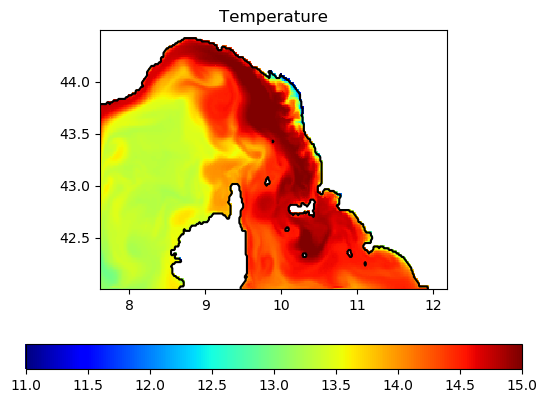

In [98]:
plotvar(temp[:,:,end],cl = [11,15]); title("Temperature");

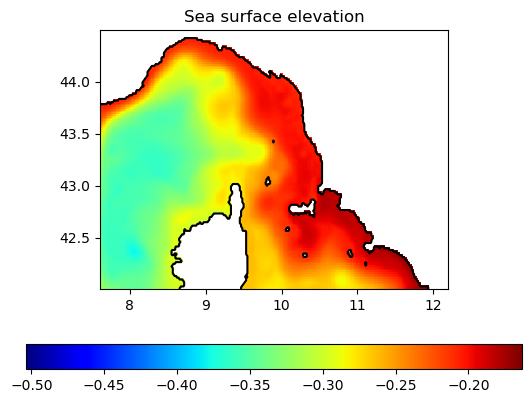

In [99]:
plotvar(zeta[:,:,end]); title("Sea surface elevation");

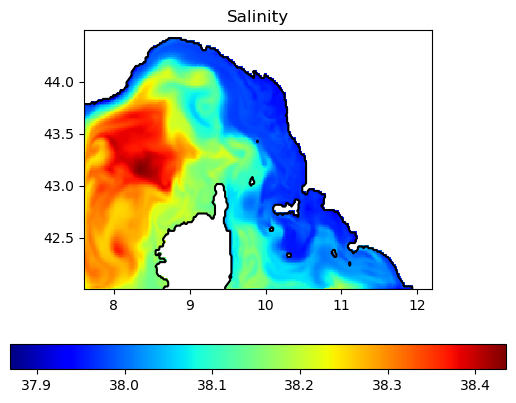

In [100]:
plotvar(salt[:,:,end]); title("Salinity");

Location of pseudo-observations

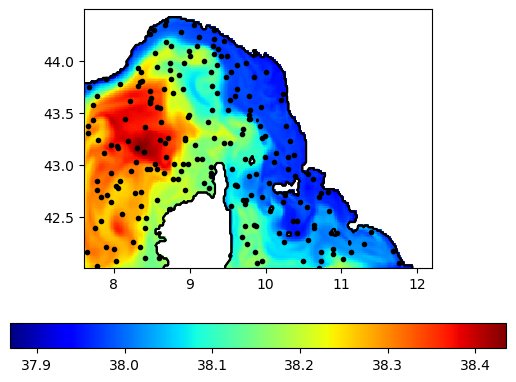

PyObject <matplotlib.contour.QuadContourSet object at 0x7fd621060640>

In [101]:
sel = (rand(Float64,size(temp)) .< 0.01) .& mask;
sel_last = sel .& (time3 .== maximum(time3))
plotvar(salt[:,:,end])
plot(lon3[sel_last],lat3[sel_last],"k.")
contour(lon,lat,Int.(mask),[0.5],colors="k")

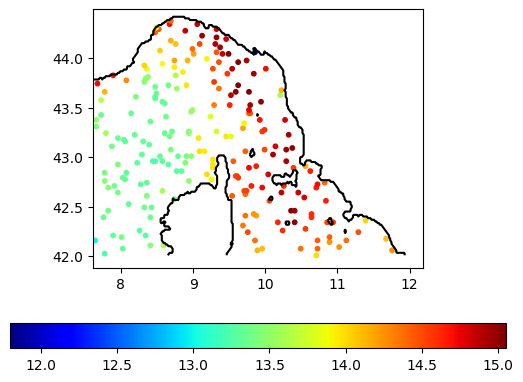

In [102]:
PyPlot.scatter(lon3[sel_last],lat3[sel_last],10,temp[sel_last]; cmap=cmap);
colorbar(orientation="horizontal");
contour(lon,lat,mask,[0.5],colors="k");
gca()[:set_aspect](1/cos(pi * mean(lat)/180))

In [103]:
X = vcat(lon3[sel]',lat3[sel]',cos.(2*pi*doy3[sel]/365)',sin.(2*pi*doy3[sel]/365)',temp[sel]',zeta[sel]')
Y = salt[sel]'

@show size(X)
@show size(Y)

meanX = mean(X,dims=2)
meanY = mean(Y,dims=2)

X = X .- meanX
Y = Y .- meanY


size(X) = (6, 842)
size(Y) = (1, 842)


1×842 Matrix{Float32}:
 0.0181198  -0.166592  -0.170803  …  -0.134399  -0.150875  -0.140079

In [104]:
m = Chain(Dense(size(X,1),4,σ),
    Dense(4,4,σ),
    Dense(4,4,σ),
    Dense(4,3,σ),
    Dense(3,1),
)
loss(x, y) = Flux.mse(m(x), y)
evalcb = () -> @show sqrt(loss(X, Y))

#51 (generic function with 1 method)

In [105]:
#m = gpu(m)
#X = gpu(Float32.(X))
#Y = gpu(Float32.(Y))


In [106]:
size(X)

(6, 842)

In [107]:
dataset = batchview((X,Y),size=300);
Xbatch,Ybatch = first(dataset)

#@show m(Xbatch)
#@show loss(Xbatch,Ybatch)

evalcb()

sqrt(loss(X, Y)) = 0.3483462720764487


0.3483462720764487

In [108]:
#η = 0.001 # learning rate

@time Flux.@epochs 2000 Flux.train!(loss, Flux.params(m), dataset, ADAM(), cb =  throttle(evalcb,100))

┌ Info: Epoch 1
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135


sqrt(loss(X, Y)) = 0.3451062333740944
sqrt(loss(X, Y)) = 0.33864717850584103
sqrt(loss(X, Y)) = 0.3322212764188367
sqrt(loss(X, Y)) = 0.3258298443648763
sqrt(loss(X, Y)) = 0.3194743053355915
sqrt(loss(X, Y)) = 0.3131561708560307
sqrt(loss(X, Y)) = 0.3068770463256508
sqrt(loss(X, Y)) = 0.30063839653753477
sqrt(loss(X, Y)) = 0.29444177930421395
sqrt(loss(X, Y)) = 0.2882889266036504
sqrt(loss(X, Y)) = 0.282181309116694
sqrt(loss(X, Y)) = 0.27612092631016383
sqrt(loss(X, Y)) = 0.27011028795717407
sqrt(loss(X, Y)) = 0.2641518996842673
sqrt(loss(X, Y)) = 0.25824808284096334
sqrt(loss(X, Y)) = 0.25240186743104315
sqrt(loss(X, Y)) = 0.24661661945627156
sqrt(loss(X, Y)) = 0.24089600498735128
sqrt(loss(X, Y)) = 0.23524397744891232
sqrt(loss(X, Y)) = 0.22966478593351225
sqrt(loss(X, Y)) = 0.2241630350623298
sqrt(loss(X, Y)) = 0.2187437197158513
sqrt(loss(X, Y)) = 0.21341219450050844
sqrt(loss(X, Y)) = 0.2081742764978063
sqrt(loss(X, Y)) = 0.203036219155666
sqrt(loss(X, Y)) = 0.19800478227925866
s

┌ Info: Epoch 2
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 3
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 4
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 5
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 6
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 7
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 8
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 9
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 10
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 11
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 12
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:

sqrt(loss(X, Y)) = 0.13446137545831355
sqrt(loss(X, Y)) = 0.13409783445749276
sqrt(loss(X, Y)) = 0.13413396553931803
sqrt(loss(X, Y)) = 0.13421985953096902
sqrt(loss(X, Y)) = 0.13429983972894027
sqrt(loss(X, Y)) = 0.13437273090708304
sqrt(loss(X, Y)) = 0.1344248796997546
sqrt(loss(X, Y)) = 0.13405643944885598
sqrt(loss(X, Y)) = 0.1340915031452136
sqrt(loss(X, Y)) = 0.1341759337004974
sqrt(loss(X, Y)) = 0.1342546620404715
sqrt(loss(X, Y)) = 0.1343267320161845
sqrt(loss(X, Y)) = 0.13437805095969896
sqrt(loss(X, Y)) = 0.1340087269468634
sqrt(loss(X, Y)) = 0.1340432878986092
sqrt(loss(X, Y)) = 0.13412697832495807
sqrt(loss(X, Y)) = 0.1342049600108606
sqrt(loss(X, Y)) = 0.13427629903534044
sqrt(loss(X, Y)) = 0.1343268269154131
sqrt(loss(X, Y)) = 0.1339574689593661
sqrt(loss(X, Y)) = 0.1339911689214245
sqrt(loss(X, Y)) = 0.1340740510770439
sqrt(loss(X, Y)) = 0.13415073327404423
sqrt(loss(X, Y)) = 0.13422127733297318
sqrt(loss(X, Y)) = 0.1341682576812144
sqrt(loss(X, Y)) = 0.13421344478278174

┌ Info: Epoch 55
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 56
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 57
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 58
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 59
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 60
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 61
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 62
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 63
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 64
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 65
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/t

sqrt(loss(X, Y)) = 0.13406481954480232
sqrt(loss(X, Y)) = 0.13400328171526235
sqrt(loss(X, Y)) = 0.13404014936767847
sqrt(loss(X, Y)) = 0.1339776957716335
sqrt(loss(X, Y)) = 0.1340134512661755
sqrt(loss(X, Y)) = 0.13393815612014087
sqrt(loss(X, Y)) = 0.13397343212044882
sqrt(loss(X, Y)) = 0.13391130589750233
sqrt(loss(X, Y)) = 0.13394646167152205
sqrt(loss(X, Y)) = 0.1338712732363003
sqrt(loss(X, Y)) = 0.13390533817887243
sqrt(loss(X, Y)) = 0.13384321683586506
sqrt(loss(X, Y)) = 0.13387788199383552
sqrt(loss(X, Y)) = 0.13380258371516565
sqrt(loss(X, Y)) = 0.13383612571124576
sqrt(loss(X, Y)) = 0.1337739332004427
sqrt(loss(X, Y)) = 0.13380810341508106
sqrt(loss(X, Y)) = 0.13373246619065934
sqrt(loss(X, Y)) = 0.1337654194466778
sqrt(loss(X, Y)) = 0.1337029409337278
sqrt(loss(X, Y)) = 0.13373655921007993
sqrt(loss(X, Y)) = 0.13365765355303905
sqrt(loss(X, Y)) = 0.13368986498233318
sqrt(loss(X, Y)) = 0.13362731708631917
sqrt(loss(X, Y)) = 0.13366052929509853
sqrt(loss(X, Y)) = 0.1335812428

┌ Info: Epoch 92
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 93
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 94
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 95
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 96
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 97
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 98
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 99
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 100
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 101
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 102
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimis

sqrt(loss(X, Y)) = 0.13312847466900793
sqrt(loss(X, Y)) = 0.13315997079609723
sqrt(loss(X, Y)) = 0.1330977373922246
sqrt(loss(X, Y)) = 0.133127485522221
sqrt(loss(X, Y)) = 0.1330617477849838
sqrt(loss(X, Y)) = 0.13299157394080005
sqrt(loss(X, Y)) = 0.13302201493103855
sqrt(loss(X, Y)) = 0.13295850466137635
sqrt(loss(X, Y)) = 0.13298708573926532
sqrt(loss(X, Y)) = 0.13291979710192517
sqrt(loss(X, Y)) = 0.13284808944827
sqrt(loss(X, Y)) = 0.1328768489770642
sqrt(loss(X, Y)) = 0.13281149815456475
sqrt(loss(X, Y)) = 0.13283830424921356
sqrt(loss(X, Y)) = 0.1327604794335215
sqrt(loss(X, Y)) = 0.13268688007904345
sqrt(loss(X, Y)) = 0.13271412553773138
sqrt(loss(X, Y)) = 0.13264748375067728
sqrt(loss(X, Y)) = 0.13267263987333133
sqrt(loss(X, Y)) = 0.13259297714523174
sqrt(loss(X, Y)) = 0.13251764055423715
sqrt(loss(X, Y)) = 0.13254306393694026
sqrt(loss(X, Y)) = 0.13247448778900867
sqrt(loss(X, Y)) = 0.1324977245070091
sqrt(loss(X, Y)) = 0.13241565381498002
sqrt(loss(X, Y)) = 0.13233808761132

┌ Info: Epoch 137
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 138
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 139
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 140
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 141
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 142
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 143
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 144
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 145
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 146
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 147
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src

sqrt(loss(X, Y)) = 0.13157035048376556
sqrt(loss(X, Y)) = 0.13148180745746463
sqrt(loss(X, Y)) = 0.1314940980223518
sqrt(loss(X, Y)) = 0.13139462390922724
sqrt(loss(X, Y)) = 0.13130654694129615
sqrt(loss(X, Y)) = 0.1313194119379568
sqrt(loss(X, Y)) = 0.13122700753254068
sqrt(loss(X, Y)) = 0.13113900319063038
sqrt(loss(X, Y)) = 0.13115050892099644
sqrt(loss(X, Y)) = 0.13105689197165388
sqrt(loss(X, Y)) = 0.130967584931588
sqrt(loss(X, Y)) = 0.13097749999221647
sqrt(loss(X, Y)) = 0.13088213501149937
sqrt(loss(X, Y)) = 0.1307910584459776
sqrt(loss(X, Y)) = 0.1307992067573411
sqrt(loss(X, Y)) = 0.1307017072974762
sqrt(loss(X, Y)) = 0.13060627191845708
sqrt(loss(X, Y)) = 0.13061235057492968
sqrt(loss(X, Y)) = 0.13051272837404052
sqrt(loss(X, Y)) = 0.13041517659708868
sqrt(loss(X, Y)) = 0.13041929979964803
sqrt(loss(X, Y)) = 0.13031015917378475
sqrt(loss(X, Y)) = 0.1302104371838259
sqrt(loss(X, Y)) = 0.13021281414596822
sqrt(loss(X, Y)) = 0.13010171871388584
sqrt(loss(X, Y)) = 0.130000053614

┌ Info: Epoch 181
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 182
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 183
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 184
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 185
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 186
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 187
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 188
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 189
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 190
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 191
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src

sqrt(loss(X, Y)) = 0.12879657159997682
sqrt(loss(X, Y)) = 0.12866980179647752
sqrt(loss(X, Y)) = 0.1285449624920435
sqrt(loss(X, Y)) = 0.1285293134664993
sqrt(loss(X, Y)) = 0.12839883187691065
sqrt(loss(X, Y)) = 0.12827041983622173
sqrt(loss(X, Y)) = 0.12815576852305766
sqrt(loss(X, Y)) = 0.1281381351212398
sqrt(loss(X, Y)) = 0.12800468397240042
sqrt(loss(X, Y)) = 0.12787294697770504
sqrt(loss(X, Y)) = 0.1277547556100519
sqrt(loss(X, Y)) = 0.127733342293944
sqrt(loss(X, Y)) = 0.12759560994608304
sqrt(loss(X, Y)) = 0.1274595357712804
sqrt(loss(X, Y)) = 0.12732755800093437
sqrt(loss(X, Y)) = 0.12730129595518969
sqrt(loss(X, Y)) = 0.12716080544622213
sqrt(loss(X, Y)) = 0.12702068696269508
sqrt(loss(X, Y)) = 0.12688424067061785
sqrt(loss(X, Y)) = 0.12685381461398723
sqrt(loss(X, Y)) = 0.1267082280948123
sqrt(loss(X, Y)) = 0.12656303078384024
sqrt(loss(X, Y)) = 0.12642134773328242
sqrt(loss(X, Y)) = 0.12629098370207406
sqrt(loss(X, Y)) = 0.12625644613390205
sqrt(loss(X, Y)) = 0.126104546466

┌ Info: Epoch 222
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 223
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 224
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 225
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 226
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 227
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 228
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 229
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 230
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 231
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 232
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src

sqrt(loss(X, Y)) = 0.1228393428005725
sqrt(loss(X, Y)) = 0.12267326583955897
sqrt(loss(X, Y)) = 0.12250524422619237
sqrt(loss(X, Y)) = 0.12232517203129706
sqrt(loss(X, Y)) = 0.12215521038849099
sqrt(loss(X, Y)) = 0.12198436745165675
sqrt(loss(X, Y)) = 0.12181076071606207
sqrt(loss(X, Y)) = 0.12162477928771473
sqrt(loss(X, Y)) = 0.1214471741881058
sqrt(loss(X, Y)) = 0.12125811682315392
sqrt(loss(X, Y)) = 0.12107702475744163
sqrt(loss(X, Y)) = 0.12089449015154559
sqrt(loss(X, Y)) = 0.12069891103570173
sqrt(loss(X, Y)) = 0.12051149568895123
sqrt(loss(X, Y)) = 0.12031227474804346
sqrt(loss(X, Y)) = 0.12012039801078409
sqrt(loss(X, Y)) = 0.11991658965838475
sqrt(loss(X, Y)) = 0.11972132002118546
sqrt(loss(X, Y)) = 0.1195134001261065
sqrt(loss(X, Y)) = 0.11931333983840295
sqrt(loss(X, Y)) = 0.11910118271243436
sqrt(loss(X, Y)) = 0.11889689277463594
sqrt(loss(X, Y)) = 0.11868036031838876
sqrt(loss(X, Y)) = 0.11847179571237422
sqrt(loss(X, Y)) = 0.11824883774806592
sqrt(loss(X, Y)) = 0.1180364

┌ Info: Epoch 269
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 270
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 271
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 272
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 273
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 274
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 275
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 276
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 277
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 278
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 279
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src

sqrt(loss(X, Y)) = 0.11471712910183748
sqrt(loss(X, Y)) = 0.11445195503005724
sqrt(loss(X, Y)) = 0.11419850831859699
sqrt(loss(X, Y)) = 0.11394211846893741
sqrt(loss(X, Y)) = 0.11366876812941223
sqrt(loss(X, Y)) = 0.11340704788222597
sqrt(loss(X, Y)) = 0.1131423652858
sqrt(loss(X, Y)) = 0.11287202406652247
sqrt(loss(X, Y)) = 0.1125882033780836
sqrt(loss(X, Y)) = 0.11231485860618186
sqrt(loss(X, Y)) = 0.11203786862352227
sqrt(loss(X, Y)) = 0.11175749325708327
sqrt(loss(X, Y)) = 0.11147433684981385
sqrt(loss(X, Y)) = 0.11117771947034769
sqrt(loss(X, Y)) = 0.11089248244653487
sqrt(loss(X, Y)) = 0.11060229225491991
sqrt(loss(X, Y)) = 0.11030873104484976
sqrt(loss(X, Y)) = 0.11001225215821718
sqrt(loss(X, Y)) = 0.1097022519512609
sqrt(loss(X, Y)) = 0.10940287692779435
sqrt(loss(X, Y)) = 0.10909939555197515
sqrt(loss(X, Y)) = 0.10879259258098223
sqrt(loss(X, Y)) = 0.10848283066677956
sqrt(loss(X, Y)) = 0.1081595019529196
sqrt(loss(X, Y)) = 0.10784795714320089
sqrt(loss(X, Y)) = 0.10753112281

┌ Info: Epoch 308
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 309
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 310
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 311
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 312
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 313
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 314
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 315
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 316
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 317
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 318
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src

sqrt(loss(X, Y)) = 0.09628706595745964
sqrt(loss(X, Y)) = 0.09588956865146232
sqrt(loss(X, Y)) = 0.09548028987179508
sqrt(loss(X, Y)) = 0.09506787930774538
sqrt(loss(X, Y)) = 0.09465395631048631
sqrt(loss(X, Y)) = 0.094247940588607
sqrt(loss(X, Y)) = 0.09383032503118459
sqrt(loss(X, Y)) = 0.0934096248718368
sqrt(loss(X, Y)) = 0.09299186125653353
sqrt(loss(X, Y)) = 0.09257245296630874
sqrt(loss(X, Y)) = 0.09215076569416891
sqrt(loss(X, Y)) = 0.0917269459352282
sqrt(loss(X, Y)) = 0.09130111089171072
sqrt(loss(X, Y)) = 0.09087336165519234
sqrt(loss(X, Y)) = 0.09044378442722076
sqrt(loss(X, Y)) = 0.0900124960847129
sqrt(loss(X, Y)) = 0.08957950124336683
sqrt(loss(X, Y)) = 0.0891451960466234
sqrt(loss(X, Y)) = 0.08870925862507312
sqrt(loss(X, Y)) = 0.08825488354162772
sqrt(loss(X, Y)) = 0.08781919247676079
sqrt(loss(X, Y)) = 0.08738186298364606
sqrt(loss(X, Y)) = 0.08694218359714542
sqrt(loss(X, Y)) = 0.08648364835970156
sqrt(loss(X, Y)) = 0.08604419285570106
sqrt(loss(X, Y)) = 0.0856033358

┌ Info: Epoch 364
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 365
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 366
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 367
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 368
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 369
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 370
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 371
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 372
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 373
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 374
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src

sqrt(loss(X, Y)) = 0.07199974542341861
sqrt(loss(X, Y)) = 0.07161449179958072
sqrt(loss(X, Y)) = 0.07120652727464248
sqrt(loss(X, Y)) = 0.07083138242392535
sqrt(loss(X, Y)) = 0.07045071996952398
sqrt(loss(X, Y)) = 0.0700821243963188
sqrt(loss(X, Y)) = 0.06969380501568749
sqrt(loss(X, Y)) = 0.06934154150730212
sqrt(loss(X, Y)) = 0.06899333422369738
sqrt(loss(X, Y)) = 0.06864735360157247
sqrt(loss(X, Y)) = 0.06830821745978612
sqrt(loss(X, Y)) = 0.06797643444857743
sqrt(loss(X, Y)) = 0.06765241659939251
sqrt(loss(X, Y)) = 0.0673365773295512
sqrt(loss(X, Y)) = 0.06703213597253957
sqrt(loss(X, Y)) = 0.06673309042352528
sqrt(loss(X, Y)) = 0.06644704727907443
sqrt(loss(X, Y)) = 0.0661663408198989
sqrt(loss(X, Y)) = 0.06590349828265106
sqrt(loss(X, Y)) = 0.06564289017664501
sqrt(loss(X, Y)) = 0.0654022863628625
sqrt(loss(X, Y)) = 0.06516335914429397
sqrt(loss(X, Y)) = 0.06493825907011079
sqrt(loss(X, Y)) = 0.06472067392155814
sqrt(loss(X, Y)) = 0.06451623913192084
sqrt(loss(X, Y)) = 0.06431878

┌ Info: Epoch 419
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 420
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 421
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 422
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 423
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 424
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 425
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 426
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 427
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 428
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 429
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src

sqrt(loss(X, Y)) = 0.06143952010041313


┌ Info: Epoch 477
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135


sqrt(loss(X, Y)) = 0.061424006618960934
sqrt(loss(X, Y)) = 0.06137250057214394
sqrt(loss(X, Y)) = 0.0613567727404746
sqrt(loss(X, Y)) = 0.06130964581288766
sqrt(loss(X, Y)) = 0.061292481077374686
sqrt(loss(X, Y)) = 0.06123915868252256
sqrt(loss(X, Y)) = 0.06122547631138677
sqrt(loss(X, Y)) = 0.06117757314420683
sqrt(loss(X, Y)) = 0.06116458505337068
sqrt(loss(X, Y)) = 0.06111599323571645
sqrt(loss(X, Y)) = 0.06110391083706878
sqrt(loss(X, Y)) = 0.061055415357273185
sqrt(loss(X, Y)) = 0.06104745946492978
sqrt(loss(X, Y)) = 0.06100008430581263
sqrt(loss(X, Y)) = 0.06099078395776146
sqrt(loss(X, Y)) = 0.060943282848084944
sqrt(loss(X, Y)) = 0.060936938393250976
sqrt(loss(X, Y)) = 0.060895009922774544
sqrt(loss(X, Y)) = 0.0608864110607203
sqrt(loss(X, Y)) = 0.06083860784629258
sqrt(loss(X, Y)) = 0.06083293698736168
sqrt(loss(X, Y)) = 0.0607861046932033
sqrt(loss(X, Y)) = 0.06078037651704921
sqrt(loss(X, Y)) = 0.06073386339414689
sqrt(loss(X, Y)) = 0.060727681800863936
sqrt(loss(X, Y)) = 0.

┌ Info: Epoch 478
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 479
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 480
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 481
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 482
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 483
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 484
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 485
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 486
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 487
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 488
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src

sqrt(loss(X, Y)) = 0.05998385415750084
sqrt(loss(X, Y)) = 0.05993206728637904
sqrt(loss(X, Y)) = 0.05992997514084063
sqrt(loss(X, Y)) = 0.05988029937494309
sqrt(loss(X, Y)) = 0.05987939379261729
sqrt(loss(X, Y)) = 0.05983183722348977
sqrt(loss(X, Y)) = 0.05982914177164244
sqrt(loss(X, Y)) = 0.059801051420320224
sqrt(loss(X, Y)) = 0.059807329858487523
sqrt(loss(X, Y)) = 0.059778050733543246
sqrt(loss(X, Y)) = 0.059785648084241416
sqrt(loss(X, Y)) = 0.059738701709618466
sqrt(loss(X, Y)) = 0.05973494501676393
sqrt(loss(X, Y)) = 0.05968880011972144
sqrt(loss(X, Y)) = 0.05968704893145025
sqrt(loss(X, Y)) = 0.059642665841776486
sqrt(loss(X, Y)) = 0.05964076124722964
sqrt(loss(X, Y)) = 0.05959798357608976
sqrt(loss(X, Y)) = 0.05959583359371474
sqrt(loss(X, Y)) = 0.05955453106257696
sqrt(loss(X, Y)) = 0.05955213869885357
sqrt(loss(X, Y)) = 0.059512194446826934
sqrt(loss(X, Y)) = 0.05951161820115469
sqrt(loss(X, Y)) = 0.05947282449376067
sqrt(loss(X, Y)) = 0.05947195693169601
sqrt(loss(X, Y)) =

┌ Info: Epoch 533
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 534
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 535
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 536
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 537
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 538
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 539
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 540
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 541
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 542
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 543
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src

sqrt(loss(X, Y)) = 0.058924748702005786
sqrt(loss(X, Y)) = 0.058922899977245306
sqrt(loss(X, Y)) = 0.058895498502876044
sqrt(loss(X, Y)) = 0.05889140247417169
sqrt(loss(X, Y)) = 0.05886470696964911
sqrt(loss(X, Y)) = 0.05886018329248878
sqrt(loss(X, Y)) = 0.058833965302580844
sqrt(loss(X, Y)) = 0.05883040051513805
sqrt(loss(X, Y)) = 0.05880346073023309
sqrt(loss(X, Y)) = 0.05879910234693353
sqrt(loss(X, Y)) = 0.05877277728230707
sqrt(loss(X, Y)) = 0.058768176936555026
sqrt(loss(X, Y)) = 0.058742379015243845
sqrt(loss(X, Y)) = 0.05873766535520031
sqrt(loss(X, Y)) = 0.05871238260419905
sqrt(loss(X, Y)) = 0.058707567653039784
sqrt(loss(X, Y)) = 0.05868281701741554
sqrt(loss(X, Y)) = 0.05867787938088268
sqrt(loss(X, Y)) = 0.05865369128485822
sqrt(loss(X, Y)) = 0.05864859336121556
sqrt(loss(X, Y)) = 0.05862500648174645
sqrt(loss(X, Y)) = 0.058619701898141655
sqrt(loss(X, Y)) = 0.05859675965319988
sqrt(loss(X, Y)) = 0.058591200844775954
sqrt(loss(X, Y)) = 0.05856894705814123
sqrt(loss(X, Y))

┌ Info: Epoch 590
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 591
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 592
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 593
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 594
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 595
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 596
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 597
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 598
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 599
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 600
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src

sqrt(loss(X, Y)) = 0.058234084416918255
sqrt(loss(X, Y)) = 0.058224559027680776
sqrt(loss(X, Y)) = 0.0582132823878926
sqrt(loss(X, Y)) = 0.05820309081532838
sqrt(loss(X, Y)) = 0.05819222852397791
sqrt(loss(X, Y)) = 0.05818205966108597
sqrt(loss(X, Y)) = 0.05817139880571442
sqrt(loss(X, Y)) = 0.058161386178840056
sqrt(loss(X, Y)) = 0.05815116298637364
sqrt(loss(X, Y)) = 0.05814060629513853
sqrt(loss(X, Y)) = 0.058130723303326165
sqrt(loss(X, Y)) = 0.058119217782004774
sqrt(loss(X, Y)) = 0.058109674072938475
sqrt(loss(X, Y)) = 0.05809665438726106
sqrt(loss(X, Y)) = 0.058087285177587045
sqrt(loss(X, Y)) = 0.05807415444869369
sqrt(loss(X, Y)) = 0.05806499919304367
sqrt(loss(X, Y)) = 0.05805175119006148
sqrt(loss(X, Y)) = 0.05804316315649072
sqrt(loss(X, Y)) = 0.058029595794441696
sqrt(loss(X, Y)) = 0.05802136927465001
sqrt(loss(X, Y)) = 0.05800769283187214
sqrt(loss(X, Y)) = 0.05799962217795077
sqrt(loss(X, Y)) = 0.05798659506949445
sqrt(loss(X, Y)) = 0.05797881174662178
sqrt(loss(X, Y)) =

┌ Info: Epoch 641
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 642
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 643
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 644
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 645
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 646
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 647
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 648
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 649
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 650
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 651
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src

sqrt(loss(X, Y)) = 0.05764935304974698
sqrt(loss(X, Y)) = 0.057646273620597356
sqrt(loss(X, Y)) = 0.05763032903180904
sqrt(loss(X, Y)) = 0.0576275513860393
sqrt(loss(X, Y)) = 0.05761220384692716
sqrt(loss(X, Y)) = 0.05760963314455915
sqrt(loss(X, Y)) = 0.057594081116174006
sqrt(loss(X, Y)) = 0.05759172453268606
sqrt(loss(X, Y)) = 0.05757594459191627
sqrt(loss(X, Y)) = 0.057573810173290725
sqrt(loss(X, Y)) = 0.05755771122272418
sqrt(loss(X, Y)) = 0.057555821485343654
sqrt(loss(X, Y)) = 0.05753854931704158
sqrt(loss(X, Y)) = 0.05753711771523291
sqrt(loss(X, Y)) = 0.05751980361534432
sqrt(loss(X, Y)) = 0.05751874670107765
sqrt(loss(X, Y)) = 0.05750139547127051
sqrt(loss(X, Y)) = 0.05749955258871089
sqrt(loss(X, Y)) = 0.057483389704529445
sqrt(loss(X, Y)) = 0.05748185408753444
sqrt(loss(X, Y)) = 0.05746558410967551
sqrt(loss(X, Y)) = 0.0574643111587807
sqrt(loss(X, Y)) = 0.05744791436863707
sqrt(loss(X, Y)) = 0.05744687177736662
sqrt(loss(X, Y)) = 0.05743034409846782
sqrt(loss(X, Y)) = 0.0

┌ Info: Epoch 698
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 699
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 700
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 701
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 702
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 703
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 704
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 705
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 706
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 707
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 708
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src

sqrt(loss(X, Y)) = 0.05719283365191397
sqrt(loss(X, Y)) = 0.05719467651467844
sqrt(loss(X, Y)) = 0.057177139625273814
sqrt(loss(X, Y)) = 0.057178604017125406
sqrt(loss(X, Y)) = 0.05716220907121001
sqrt(loss(X, Y)) = 0.05716576008167262
sqrt(loss(X, Y)) = 0.057147300746508575
sqrt(loss(X, Y)) = 0.057148972158873663
sqrt(loss(X, Y)) = 0.05713331672286481
sqrt(loss(X, Y)) = 0.05713985139681925
sqrt(loss(X, Y)) = 0.05712014579700411
sqrt(loss(X, Y)) = 0.05712321591140951
sqrt(loss(X, Y)) = 0.05710641303354917
sqrt(loss(X, Y)) = 0.05711311718349053
sqrt(loss(X, Y)) = 0.05709218777090291
sqrt(loss(X, Y)) = 0.057095380247337686
sqrt(loss(X, Y)) = 0.05707819158428629
sqrt(loss(X, Y)) = 0.05708571685798464
sqrt(loss(X, Y)) = 0.057066570971089886
sqrt(loss(X, Y)) = 0.05707405707518032
sqrt(loss(X, Y)) = 0.057055022765257944
sqrt(loss(X, Y)) = 0.05706392094151823
sqrt(loss(X, Y)) = 0.057044279601195534
sqrt(loss(X, Y)) = 0.05705366894905468
sqrt(loss(X, Y)) = 0.05703343160418993
sqrt(loss(X, Y)) 

┌ Info: Epoch 750
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 751
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 752
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 753
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 754
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 755
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 756
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 757
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 758
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 759
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 760
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src

sqrt(loss(X, Y)) = 0.05694022453517065
sqrt(loss(X, Y)) = 0.056955683897366285
sqrt(loss(X, Y)) = 0.05693232788006943
sqrt(loss(X, Y)) = 0.05694814394466227
sqrt(loss(X, Y)) = 0.05692608635453704
sqrt(loss(X, Y)) = 0.05694190104324332
sqrt(loss(X, Y)) = 0.056918941180793436
sqrt(loss(X, Y)) = 0.05693406183086528
sqrt(loss(X, Y)) = 0.05691092344027283
sqrt(loss(X, Y)) = 0.05692608276023741
sqrt(loss(X, Y)) = 0.056902801625308704
sqrt(loss(X, Y)) = 0.05691784750664774
sqrt(loss(X, Y)) = 0.05689445687982768
sqrt(loss(X, Y)) = 0.056909386137382084
sqrt(loss(X, Y)) = 0.05688591696892082
sqrt(loss(X, Y)) = 0.05690070463449574
sqrt(loss(X, Y)) = 0.056877182509976074
sqrt(loss(X, Y)) = 0.056891802046954085
sqrt(loss(X, Y)) = 0.05686558894862196
sqrt(loss(X, Y)) = 0.056880091384689864
sqrt(loss(X, Y)) = 0.0568536534780626
sqrt(loss(X, Y)) = 0.05686871801847493
sqrt(loss(X, Y)) = 0.05684417494578205
sqrt(loss(X, Y)) = 0.05686281002144128
sqrt(loss(X, Y)) = 0.05683756358709785
sqrt(loss(X, Y)) = 

┌ Info: Epoch 798
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 799
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 800
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 801
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 802
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 803
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 804
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 805
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 806
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 807
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 808
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src

sqrt(loss(X, Y)) = 0.05675998271232353
sqrt(loss(X, Y)) = 0.056772314552168975
sqrt(loss(X, Y)) = 0.05678879327463814
sqrt(loss(X, Y)) = 0.05677842810148282
sqrt(loss(X, Y)) = 0.05674673037775183
sqrt(loss(X, Y)) = 0.05679189232881522
sqrt(loss(X, Y)) = 0.0568407453555807
sqrt(loss(X, Y)) = 0.05679248550863774
sqrt(loss(X, Y)) = 0.05677239184214742
sqrt(loss(X, Y)) = 0.05674810504741858
sqrt(loss(X, Y)) = 0.05672433500161262
sqrt(loss(X, Y)) = 0.05676028321226239
sqrt(loss(X, Y)) = 0.05680903882042214
sqrt(loss(X, Y)) = 0.056760578364140855
sqrt(loss(X, Y)) = 0.056745956099711344
sqrt(loss(X, Y)) = 0.05673542423715397
sqrt(loss(X, Y)) = 0.05677798416572334
sqrt(loss(X, Y)) = 0.056740530790977455
sqrt(loss(X, Y)) = 0.056727780964528435
sqrt(loss(X, Y)) = 0.05672104632897028
sqrt(loss(X, Y)) = 0.05676997711006849
sqrt(loss(X, Y)) = 0.056717466923016914
sqrt(loss(X, Y)) = 0.05670416788162051
sqrt(loss(X, Y)) = 0.05681624682234211
sqrt(loss(X, Y)) = 0.056918669966415876
sqrt(loss(X, Y)) = 

┌ Info: Epoch 849
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 850
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 851
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 852
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 853
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 854
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 855
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 856
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 857
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 858
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 859
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src

sqrt(loss(X, Y)) = 0.05641186187671783
sqrt(loss(X, Y)) = 0.056015514146749844
sqrt(loss(X, Y)) = 0.05597869589575177
sqrt(loss(X, Y)) = 0.0563674190340678
sqrt(loss(X, Y)) = 0.05597349522225302
sqrt(loss(X, Y)) = 0.05593645873523682
sqrt(loss(X, Y)) = 0.0563276953466528
sqrt(loss(X, Y)) = 0.05593460780863967
sqrt(loss(X, Y)) = 0.055897587114271736
sqrt(loss(X, Y)) = 0.056284384379708084
sqrt(loss(X, Y)) = 0.05589264483036015
sqrt(loss(X, Y)) = 0.05585555552595655
sqrt(loss(X, Y)) = 0.056241672625769595
sqrt(loss(X, Y)) = 0.05585050327121168
sqrt(loss(X, Y)) = 0.05581309465027288
sqrt(loss(X, Y)) = 0.056197564965536365
sqrt(loss(X, Y)) = 0.05580851097472711
sqrt(loss(X, Y)) = 0.05577152668329082
sqrt(loss(X, Y)) = 0.05615549115775247
sqrt(loss(X, Y)) = 0.055766479207564036
sqrt(loss(X, Y)) = 0.055729161926384316
sqrt(loss(X, Y)) = 0.05611187399980955
sqrt(loss(X, Y)) = 0.05572511674447278
sqrt(loss(X, Y)) = 0.055690515789699725
sqrt(loss(X, Y)) = 0.05607407776416092
sqrt(loss(X, Y)) = 

┌ Info: Epoch 906
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 907
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 908
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 909
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 910
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 911
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 912
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 913
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 914
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 915
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 916
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src

sqrt(loss(X, Y)) = 0.055292424042606286
sqrt(loss(X, Y)) = 0.05526088416123257
sqrt(loss(X, Y)) = 0.05564256833168308
sqrt(loss(X, Y)) = 0.05525399018159047
sqrt(loss(X, Y)) = 0.05522260204775419
sqrt(loss(X, Y)) = 0.055603655077104734
sqrt(loss(X, Y)) = 0.055215620676635525
sqrt(loss(X, Y)) = 0.05518425142519178
sqrt(loss(X, Y)) = 0.05556460947605327
sqrt(loss(X, Y)) = 0.05517704090839409
sqrt(loss(X, Y)) = 0.0551457127802835
sqrt(loss(X, Y)) = 0.05552082344380765
sqrt(loss(X, Y)) = 0.05513480492481145
sqrt(loss(X, Y)) = 0.055103295977586696
sqrt(loss(X, Y)) = 0.05547823172026252
sqrt(loss(X, Y)) = 0.05509232561320308
sqrt(loss(X, Y)) = 0.05506135389530564
sqrt(loss(X, Y)) = 0.05543542864365096
sqrt(loss(X, Y)) = 0.05505038021279641
sqrt(loss(X, Y)) = 0.05501964492063363
sqrt(loss(X, Y)) = 0.055393047693558524
sqrt(loss(X, Y)) = 0.05500857268483249
sqrt(loss(X, Y)) = 0.05497815788891455
sqrt(loss(X, Y)) = 0.05535090382008166
sqrt(loss(X, Y)) = 0.054966909926500225
sqrt(loss(X, Y)) = 0

┌ Info: Epoch 962
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 963
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 964
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 965
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 966
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 967
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 968
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 969
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 970
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 971
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 972
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src

sqrt(loss(X, Y)) = 0.05496333495059453
sqrt(loss(X, Y)) = 0.05458528011350464
sqrt(loss(X, Y)) = 0.05455585382962924
sqrt(loss(X, Y)) = 0.0549137636646829
sqrt(loss(X, Y)) = 0.054543281905376266
sqrt(loss(X, Y)) = 0.054514454741997426
sqrt(loss(X, Y)) = 0.05486996854541493
sqrt(loss(X, Y)) = 0.05450186233171069
sqrt(loss(X, Y)) = 0.0544737618528227
sqrt(loss(X, Y)) = 0.05482777761000755
sqrt(loss(X, Y)) = 0.054460833646142195
sqrt(loss(X, Y)) = 0.05443319394158901
sqrt(loss(X, Y)) = 0.05478972900413834
sqrt(loss(X, Y)) = 0.05441933590109971
sqrt(loss(X, Y)) = 0.054396039869198005
sqrt(loss(X, Y)) = 0.05474679856242539
sqrt(loss(X, Y)) = 0.05438212814215862
sqrt(loss(X, Y)) = 0.05435731543881325
sqrt(loss(X, Y)) = 0.05470848221093677
sqrt(loss(X, Y)) = 0.05434340365019669
sqrt(loss(X, Y)) = 0.0543173871329079
sqrt(loss(X, Y)) = 0.05466946747486958
sqrt(loss(X, Y)) = 0.054300729018865526
sqrt(loss(X, Y)) = 0.05427362015055359
sqrt(loss(X, Y)) = 0.05462632431956451
sqrt(loss(X, Y)) = 0.05

┌ Info: Epoch 1012
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1013
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1014
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1015
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1016
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1017
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1018
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1019
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1020
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1021
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1022
└ @ Main /home/abarth/.julia/packages/Flu

sqrt(loss(X, Y)) = 0.05395997408864137
sqrt(loss(X, Y)) = 0.05353516446715135
sqrt(loss(X, Y)) = 0.05351977857035044
sqrt(loss(X, Y)) = 0.05386999507603762
sqrt(loss(X, Y)) = 0.05375473109195139
sqrt(loss(X, Y)) = 0.053865364834046976
sqrt(loss(X, Y)) = 0.053419316856926115
sqrt(loss(X, Y)) = 0.05339998452842331
sqrt(loss(X, Y)) = 0.05375124638926193
sqrt(loss(X, Y)) = 0.05365140290087185
sqrt(loss(X, Y)) = 0.05375443535951463
sqrt(loss(X, Y)) = 0.05330015866108681
sqrt(loss(X, Y)) = 0.0532805146111932
sqrt(loss(X, Y)) = 0.05363209250790877
sqrt(loss(X, Y)) = 0.05353879846767627
sqrt(loss(X, Y)) = 0.053643887052077184
sqrt(loss(X, Y)) = 0.05317885162138726
sqrt(loss(X, Y)) = 0.053164636591694354
sqrt(loss(X, Y)) = 0.05351632874364119
sqrt(loss(X, Y)) = 0.05343603645912598
sqrt(loss(X, Y)) = 0.0535382125016165
sqrt(loss(X, Y)) = 0.05305547197543971
sqrt(loss(X, Y)) = 0.053040882297180854
sqrt(loss(X, Y)) = 0.05338943062693925
sqrt(loss(X, Y)) = 0.05331393460147185
sqrt(loss(X, Y)) = 0.0

┌ Info: Epoch 1070
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1071
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1072
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1073
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1074
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1075
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1076
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1077
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1078
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1079
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1080
└ @ Main /home/abarth/.julia/packages/Flu

sqrt(loss(X, Y)) = 0.05279421523484237
sqrt(loss(X, Y)) = 0.05285108081601608
sqrt(loss(X, Y)) = 0.05230703573380973
sqrt(loss(X, Y)) = 0.05229340474850141
sqrt(loss(X, Y)) = 0.05264203225625941
sqrt(loss(X, Y)) = 0.052716275074345814
sqrt(loss(X, Y)) = 0.05251105107014952
sqrt(loss(X, Y)) = 0.05262736800984263
sqrt(loss(X, Y)) = 0.05208349499641467
sqrt(loss(X, Y)) = 0.052103013176603624
sqrt(loss(X, Y)) = 0.05247445253161819
sqrt(loss(X, Y)) = 0.05234709940052506
sqrt(loss(X, Y)) = 0.05246498345410128
sqrt(loss(X, Y)) = 0.05191413668798173
sqrt(loss(X, Y)) = 0.05193464052730413
sqrt(loss(X, Y)) = 0.0523175550796298
sqrt(loss(X, Y)) = 0.052195304739660664
sqrt(loss(X, Y)) = 0.05231098746085735
sqrt(loss(X, Y)) = 0.05175930437378108
sqrt(loss(X, Y)) = 0.05178088620292739
sqrt(loss(X, Y)) = 0.052165124627573396
sqrt(loss(X, Y)) = 0.052044438366580986
sqrt(loss(X, Y)) = 0.05216819513651853
sqrt(loss(X, Y)) = 0.05160611192706843
sqrt(loss(X, Y)) = 0.0516288811531226
sqrt(loss(X, Y)) = 0.0

┌ Info: Epoch 1119
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1120
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1121
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1122
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1123
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1124
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1125
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1126
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1127
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1128
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1129
└ @ Main /home/abarth/.julia/packages/Flu

sqrt(loss(X, Y)) = 0.05105418439439451
sqrt(loss(X, Y)) = 0.051053016195072944
sqrt(loss(X, Y)) = 0.051419544345795945
sqrt(loss(X, Y)) = 0.05163713581411465
sqrt(loss(X, Y)) = 0.050973623027061994
sqrt(loss(X, Y)) = 0.05097287599153247
sqrt(loss(X, Y)) = 0.051339614225040006
sqrt(loss(X, Y)) = 0.051558266137394455
sqrt(loss(X, Y)) = 0.050892867024951306
sqrt(loss(X, Y)) = 0.05088695406159212
sqrt(loss(X, Y)) = 0.05125370995354878
sqrt(loss(X, Y)) = 0.05147279023959723
sqrt(loss(X, Y)) = 0.0508065919252328
sqrt(loss(X, Y)) = 0.05080596490111607
sqrt(loss(X, Y)) = 0.05117208071178126
sqrt(loss(X, Y)) = 0.05139249302630643
sqrt(loss(X, Y)) = 0.0507252999443409
sqrt(loss(X, Y)) = 0.05071944788624822
sqrt(loss(X, Y)) = 0.05108456393126292
sqrt(loss(X, Y)) = 0.05130536483846765
sqrt(loss(X, Y)) = 0.05063846102913539
sqrt(loss(X, Y)) = 0.05063249324841276
sqrt(loss(X, Y)) = 0.05099815162504323
sqrt(loss(X, Y)) = 0.05121993375690761
sqrt(loss(X, Y)) = 0.05055163555053651
sqrt(loss(X, Y)) = 0.

┌ Info: Epoch 1170
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1171
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1172
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1173
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1174
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1175
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1176
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1177
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1178
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1179
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1180
└ @ Main /home/abarth/.julia/packages/Flu

sqrt(loss(X, Y)) = 0.05014462979442887
sqrt(loss(X, Y)) = 0.049917370607028624
sqrt(loss(X, Y)) = 0.050071814845666085
sqrt(loss(X, Y)) = 0.04983865858989305
sqrt(loss(X, Y)) = 0.05000499142232712
sqrt(loss(X, Y)) = 0.04949224068927237
sqrt(loss(X, Y)) = 0.04961377792232464
sqrt(loss(X, Y)) = 0.04993302480476887
sqrt(loss(X, Y)) = 0.04936517344130381
sqrt(loss(X, Y)) = 0.049476286465839334
sqrt(loss(X, Y)) = 0.04981621958271212
sqrt(loss(X, Y)) = 0.04958326693562444
sqrt(loss(X, Y)) = 0.04975568721506475
sqrt(loss(X, Y)) = 0.04937136111933461
sqrt(loss(X, Y)) = 0.049534925911114996
sqrt(loss(X, Y)) = 0.04977421358171184
sqrt(loss(X, Y)) = 0.048992140366273834
sqrt(loss(X, Y)) = 0.04900241938256496
sqrt(loss(X, Y)) = 0.0493876617752209
sqrt(loss(X, Y)) = 0.04964402882774205
sqrt(loss(X, Y)) = 0.048908079658331945
sqrt(loss(X, Y)) = 0.048958514611033684
sqrt(loss(X, Y)) = 0.04936009105244086
sqrt(loss(X, Y)) = 0.04960173850766599
sqrt(loss(X, Y)) = 0.048805534543522766
sqrt(loss(X, Y)) =

┌ Info: Epoch 1225
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1226
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1227
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1228
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1229
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1230
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1231
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1232
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1233
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1234
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1235
└ @ Main /home/abarth/.julia/packages/Flu

sqrt(loss(X, Y)) = 0.04814805445638155
sqrt(loss(X, Y)) = 0.048558119225384985
sqrt(loss(X, Y)) = 0.048813663248726526
sqrt(loss(X, Y)) = 0.04798945853053493
sqrt(loss(X, Y)) = 0.048046848410694454
sqrt(loss(X, Y)) = 0.04845897818235692
sqrt(loss(X, Y)) = 0.048716319459557254
sqrt(loss(X, Y)) = 0.0478898752064136
sqrt(loss(X, Y)) = 0.047949256844468297
sqrt(loss(X, Y)) = 0.04836189766846968
sqrt(loss(X, Y)) = 0.0486208157552313
sqrt(loss(X, Y)) = 0.04778817042416845
sqrt(loss(X, Y)) = 0.0478486676325132
sqrt(loss(X, Y)) = 0.048263553945521426
sqrt(loss(X, Y)) = 0.04852410216854329
sqrt(loss(X, Y)) = 0.0476824099383955
sqrt(loss(X, Y)) = 0.04774407085287498
sqrt(loss(X, Y)) = 0.04815994081697593
sqrt(loss(X, Y)) = 0.048421949040528746
sqrt(loss(X, Y)) = 0.04758227538328942
sqrt(loss(X, Y)) = 0.04764470406907839
sqrt(loss(X, Y)) = 0.04806084393083118
sqrt(loss(X, Y)) = 0.04834701282682511
sqrt(loss(X, Y)) = 0.04747712315860839
sqrt(loss(X, Y)) = 0.04752531463841937
sqrt(loss(X, Y)) = 0.0

┌ Info: Epoch 1279
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1280
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1281
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1282
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1283
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1284
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1285
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1286
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1287
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1288
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1289
└ @ Main /home/abarth/.julia/packages/Flu

sqrt(loss(X, Y)) = 0.0475893495961687
sqrt(loss(X, Y)) = 0.046697401760678194
sqrt(loss(X, Y)) = 0.046759967951846726
sqrt(loss(X, Y)) = 0.04718651848189864
sqrt(loss(X, Y)) = 0.04750103625706576
sqrt(loss(X, Y)) = 0.046604660793347026
sqrt(loss(X, Y)) = 0.04666786470279633
sqrt(loss(X, Y)) = 0.04709361549374361
sqrt(loss(X, Y)) = 0.04741006897936256
sqrt(loss(X, Y)) = 0.046509692418256976
sqrt(loss(X, Y)) = 0.04657794045192936
sqrt(loss(X, Y)) = 0.04700495720322933
sqrt(loss(X, Y)) = 0.04732336478376691
sqrt(loss(X, Y)) = 0.046418936825555646
sqrt(loss(X, Y)) = 0.046487678452472925
sqrt(loss(X, Y)) = 0.046915997328973676
sqrt(loss(X, Y)) = 0.047236640684172895
sqrt(loss(X, Y)) = 0.04632629369420343
sqrt(loss(X, Y)) = 0.0463955395600506
sqrt(loss(X, Y)) = 0.04682468602218196
sqrt(loss(X, Y)) = 0.04714659137412307
sqrt(loss(X, Y)) = 0.046233326378381234
sqrt(loss(X, Y)) = 0.04630298432055414
sqrt(loss(X, Y)) = 0.04674046666199495
sqrt(loss(X, Y)) = 0.047063949311390504
sqrt(loss(X, Y)) 

┌ Info: Epoch 1332
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1333
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1334
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1335
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1336
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1337
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1338
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1339
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1340
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1341
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1342
└ @ Main /home/abarth/.julia/packages/Flu

sqrt(loss(X, Y)) = 0.046051236607216134
sqrt(loss(X, Y)) = 0.04639879239079946
sqrt(loss(X, Y)) = 0.04545896766866622
sqrt(loss(X, Y)) = 0.045528104866242806
sqrt(loss(X, Y)) = 0.04596730679617381
sqrt(loss(X, Y)) = 0.04631583420442511
sqrt(loss(X, Y)) = 0.045375130169175375
sqrt(loss(X, Y)) = 0.04544419700346546
sqrt(loss(X, Y)) = 0.04588350830641065
sqrt(loss(X, Y)) = 0.04623294385886298
sqrt(loss(X, Y)) = 0.045292310281611764
sqrt(loss(X, Y)) = 0.04536191784270197
sqrt(loss(X, Y)) = 0.04580137682878682
sqrt(loss(X, Y)) = 0.04615144530609769
sqrt(loss(X, Y)) = 0.04520884561310854
sqrt(loss(X, Y)) = 0.045278312614791025
sqrt(loss(X, Y)) = 0.04571781503902872
sqrt(loss(X, Y)) = 0.04607902962257102
sqrt(loss(X, Y)) = 0.04512851296046229
sqrt(loss(X, Y)) = 0.04519719638298374
sqrt(loss(X, Y)) = 0.045640111288030326
sqrt(loss(X, Y)) = 0.04600175118277964
sqrt(loss(X, Y)) = 0.045050734385597625
sqrt(loss(X, Y)) = 0.04511916067570923
sqrt(loss(X, Y)) = 0.04555847702819275
sqrt(loss(X, Y)) =

┌ Info: Epoch 1388
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1389
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1390
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1391
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1392
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1393
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1394
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1395
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1396
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1397
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1398
└ @ Main /home/abarth/.julia/packages/Flu

sqrt(loss(X, Y)) = 0.04542525861692786
sqrt(loss(X, Y)) = 0.044458625206348065
sqrt(loss(X, Y)) = 0.04450540149062215
sqrt(loss(X, Y)) = 0.04494271781775466
sqrt(loss(X, Y)) = 0.04533335608030489
sqrt(loss(X, Y)) = 0.044385282744373915
sqrt(loss(X, Y)) = 0.04443145222521684
sqrt(loss(X, Y)) = 0.044874525768840656
sqrt(loss(X, Y)) = 0.04526496021005321
sqrt(loss(X, Y)) = 0.04432315687669486
sqrt(loss(X, Y)) = 0.044386824286623265
sqrt(loss(X, Y)) = 0.04482444947748188
sqrt(loss(X, Y)) = 0.04521346351828097
sqrt(loss(X, Y)) = 0.04425303054000368
sqrt(loss(X, Y)) = 0.04429764506544611
sqrt(loss(X, Y)) = 0.04473980394052576
sqrt(loss(X, Y)) = 0.04513073086350401
sqrt(loss(X, Y)) = 0.04418768731488912
sqrt(loss(X, Y)) = 0.04423146483463834
sqrt(loss(X, Y)) = 0.044665300081383384
sqrt(loss(X, Y)) = 0.045055949338264276
sqrt(loss(X, Y)) = 0.044117220868578416
sqrt(loss(X, Y)) = 0.04415982832088146
sqrt(loss(X, Y)) = 0.04459912703463898
sqrt(loss(X, Y)) = 0.0449892620605481
sqrt(loss(X, Y)) = 

┌ Info: Epoch 1440
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1441
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1442
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1443
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1444
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1445
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1446
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1447
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1448
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1449
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1450
└ @ Main /home/abarth/.julia/packages/Flu

sqrt(loss(X, Y)) = 0.04371936044764103
sqrt(loss(X, Y)) = 0.04415142138922585
sqrt(loss(X, Y)) = 0.04453985544920943
sqrt(loss(X, Y)) = 0.0436227853358376
sqrt(loss(X, Y)) = 0.04365831771239712
sqrt(loss(X, Y)) = 0.04408889869008253
sqrt(loss(X, Y)) = 0.04447675693783165
sqrt(loss(X, Y)) = 0.04356329157372498
sqrt(loss(X, Y)) = 0.043597778248556665
sqrt(loss(X, Y)) = 0.0440268350796138
sqrt(loss(X, Y)) = 0.04441407427529107
sqrt(loss(X, Y)) = 0.043504347486024685
sqrt(loss(X, Y)) = 0.04353778153716338
sqrt(loss(X, Y)) = 0.04396526248182229
sqrt(loss(X, Y)) = 0.04435188819980104
sqrt(loss(X, Y)) = 0.043446000831241824
sqrt(loss(X, Y)) = 0.043478376142957714
sqrt(loss(X, Y)) = 0.04390423388443305
sqrt(loss(X, Y)) = 0.04429034298300013
sqrt(loss(X, Y)) = 0.04338832676934499
sqrt(loss(X, Y)) = 0.04341964539892191
sqrt(loss(X, Y)) = 0.0438438531477027
sqrt(loss(X, Y)) = 0.0442296564439223
sqrt(loss(X, Y)) = 0.043331397281477134
sqrt(loss(X, Y)) = 0.04336166317351469
sqrt(loss(X, Y)) = 0.043

┌ Info: Epoch 1491
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1492
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1493
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1494
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1495
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1496
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1497
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1498
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1499
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1500
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1501
└ @ Main /home/abarth/.julia/packages/Flu

sqrt(loss(X, Y)) = 0.042923805889210846
sqrt(loss(X, Y)) = 0.04332876884992519
sqrt(loss(X, Y)) = 0.04370752628301661
sqrt(loss(X, Y)) = 0.042856815057996996
sqrt(loss(X, Y)) = 0.04287642148337165
sqrt(loss(X, Y)) = 0.0432811755362681
sqrt(loss(X, Y)) = 0.043658461263678124
sqrt(loss(X, Y)) = 0.04280761322574653
sqrt(loss(X, Y)) = 0.042817704707917834
sqrt(loss(X, Y)) = 0.043214088103314084
sqrt(loss(X, Y)) = 0.04359195783065109
sqrt(loss(X, Y)) = 0.04276161192968448
sqrt(loss(X, Y)) = 0.04277809783769843
sqrt(loss(X, Y)) = 0.04318091718485983
sqrt(loss(X, Y)) = 0.043557624638492075
sqrt(loss(X, Y)) = 0.04272336770516139
sqrt(loss(X, Y)) = 0.042735720847943144
sqrt(loss(X, Y)) = 0.04313466707623048
sqrt(loss(X, Y)) = 0.04350969022079171
sqrt(loss(X, Y)) = 0.04268029768893625
sqrt(loss(X, Y)) = 0.042686071964547614
sqrt(loss(X, Y)) = 0.04307483837703495
sqrt(loss(X, Y)) = 0.043449316290362895
sqrt(loss(X, Y)) = 0.04263529319613672
sqrt(loss(X, Y)) = 0.04264767894978893
sqrt(loss(X, Y)) 

┌ Info: Epoch 1546
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1547
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1548
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1549
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1550
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1551
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1552
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1553
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1554
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1555
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1556
└ @ Main /home/abarth/.julia/packages/Flu

sqrt(loss(X, Y)) = 0.04313701370850405
sqrt(loss(X, Y)) = 0.04242736230610856
sqrt(loss(X, Y)) = 0.042378827413586825
sqrt(loss(X, Y)) = 0.042690447758308186
sqrt(loss(X, Y)) = 0.04308141459852734
sqrt(loss(X, Y)) = 0.04236972409079782
sqrt(loss(X, Y)) = 0.04236146291914948
sqrt(loss(X, Y)) = 0.04272218338715639
sqrt(loss(X, Y)) = 0.04305874202363882
sqrt(loss(X, Y)) = 0.04237290218872852
sqrt(loss(X, Y)) = 0.042320449006631344
sqrt(loss(X, Y)) = 0.042625180432571734
sqrt(loss(X, Y)) = 0.04301183531282016
sqrt(loss(X, Y)) = 0.04231890048773292
sqrt(loss(X, Y)) = 0.04230342773728504
sqrt(loss(X, Y)) = 0.04265220494963656
sqrt(loss(X, Y)) = 0.04298560499279977
sqrt(loss(X, Y)) = 0.04232569535138385
sqrt(loss(X, Y)) = 0.04226958740608367
sqrt(loss(X, Y)) = 0.042561207844598076
sqrt(loss(X, Y)) = 0.042943144690324495
sqrt(loss(X, Y)) = 0.04231113013750925
sqrt(loss(X, Y)) = 0.04225332221082055
sqrt(loss(X, Y)) = 0.04254118049783529
sqrt(loss(X, Y)) = 0.04289303981136009
sqrt(loss(X, Y)) = 

┌ Info: Epoch 1601
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1602
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1603
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1604
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1605
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1606
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1607
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1608
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1609
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1610
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1611
└ @ Main /home/abarth/.julia/packages/Flu

sqrt(loss(X, Y)) = 0.042121840406535584
sqrt(loss(X, Y)) = 0.042050452791455376
sqrt(loss(X, Y)) = 0.04229641546401086
sqrt(loss(X, Y)) = 0.04262259377964657
sqrt(loss(X, Y)) = 0.04210637460103086
sqrt(loss(X, Y)) = 0.0420324833828294
sqrt(loss(X, Y)) = 0.04227189693394646
sqrt(loss(X, Y)) = 0.04259543132661713
sqrt(loss(X, Y)) = 0.04208759128990075
sqrt(loss(X, Y)) = 0.042012565666880615
sqrt(loss(X, Y)) = 0.04224660566074407
sqrt(loss(X, Y)) = 0.04256818579504204
sqrt(loss(X, Y)) = 0.042071506608272025
sqrt(loss(X, Y)) = 0.04199560380272357
sqrt(loss(X, Y)) = 0.04222452333335994
sqrt(loss(X, Y)) = 0.04254325961931922
sqrt(loss(X, Y)) = 0.04205731393339424
sqrt(loss(X, Y)) = 0.04197913654669201
sqrt(loss(X, Y)) = 0.042199421215681425
sqrt(loss(X, Y)) = 0.0425161952348304
sqrt(loss(X, Y)) = 0.042041417030105915
sqrt(loss(X, Y)) = 0.04196212609956969
sqrt(loss(X, Y)) = 0.04217702173508573
sqrt(loss(X, Y)) = 0.04249152579299464
sqrt(loss(X, Y)) = 0.042025728870617673
sqrt(loss(X, Y)) = 0

┌ Info: Epoch 1654
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1655
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1656
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1657
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1658
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1659
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1660
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1661
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1662
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1663
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1664
└ @ Main /home/abarth/.julia/packages/Flu

sqrt(loss(X, Y)) = 0.04231581389052901
sqrt(loss(X, Y)) = 0.04195265809555066
sqrt(loss(X, Y)) = 0.04186409273707833
sqrt(loss(X, Y)) = 0.04201324082845867
sqrt(loss(X, Y)) = 0.04229546646208071
sqrt(loss(X, Y)) = 0.041944876542512395
sqrt(loss(X, Y)) = 0.04184886516842464
sqrt(loss(X, Y)) = 0.04199226818204511
sqrt(loss(X, Y)) = 0.04227128160934337
sqrt(loss(X, Y)) = 0.041929719597029944
sqrt(loss(X, Y)) = 0.041839330139703125
sqrt(loss(X, Y)) = 0.041977446682601095
sqrt(loss(X, Y)) = 0.04225519806737223
sqrt(loss(X, Y)) = 0.041921300955491916
sqrt(loss(X, Y)) = 0.04183060819966232
sqrt(loss(X, Y)) = 0.041963894467217565
sqrt(loss(X, Y)) = 0.04223886678133887
sqrt(loss(X, Y)) = 0.041913118177250096
sqrt(loss(X, Y)) = 0.04182192035274899
sqrt(loss(X, Y)) = 0.04195014441580531
sqrt(loss(X, Y)) = 0.042222846181566874
sqrt(loss(X, Y)) = 0.041904921099601804
sqrt(loss(X, Y)) = 0.04181332566971781
sqrt(loss(X, Y)) = 0.04193645234292839
sqrt(loss(X, Y)) = 0.0422029957965702
sqrt(loss(X, Y)) 

┌ Info: Epoch 1709
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1710
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1711
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1712
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1713
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1714
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1715
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1716
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1717
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1718
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1719
└ @ Main /home/abarth/.julia/packages/Flu

sqrt(loss(X, Y)) = 0.04203307349329214
sqrt(loss(X, Y)) = 0.04184654384628621
sqrt(loss(X, Y)) = 0.04173968104053496
sqrt(loss(X, Y)) = 0.04179871563642831
sqrt(loss(X, Y)) = 0.04201414377409496
sqrt(loss(X, Y)) = 0.04183882580954561
sqrt(loss(X, Y)) = 0.04173176863978103
sqrt(loss(X, Y)) = 0.041783067739776594
sqrt(loss(X, Y)) = 0.041995959623134585
sqrt(loss(X, Y)) = 0.04183092453791972
sqrt(loss(X, Y)) = 0.04172392683005857
sqrt(loss(X, Y)) = 0.041767696736178125
sqrt(loss(X, Y)) = 0.04197801854536686
sqrt(loss(X, Y)) = 0.04182315512442084
sqrt(loss(X, Y)) = 0.04171630149743907
sqrt(loss(X, Y)) = 0.04175250747767398
sqrt(loss(X, Y)) = 0.04193316596261134
sqrt(loss(X, Y)) = 0.04180743232346394
sqrt(loss(X, Y)) = 0.041685562366252364
sqrt(loss(X, Y)) = 0.041729607981631014
sqrt(loss(X, Y)) = 0.04186579865609483
sqrt(loss(X, Y)) = 0.04161522885855073
sqrt(loss(X, Y)) = 0.04154651870434907
sqrt(loss(X, Y)) = 0.04174542087408529
sqrt(loss(X, Y)) = 0.041553475341668596
sqrt(loss(X, Y)) = 

┌ Info: Epoch 1764
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1765
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1766
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1767
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1768
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1769
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1770
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1771
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1772
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1773
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1774
└ @ Main /home/abarth/.julia/packages/Flu

sqrt(loss(X, Y)) = 0.0416115851367606
sqrt(loss(X, Y)) = 0.04135800618538159
sqrt(loss(X, Y)) = 0.0413611716347235
sqrt(loss(X, Y)) = 0.0416149409573395
sqrt(loss(X, Y)) = 0.04166241866346306
sqrt(loss(X, Y)) = 0.0415226923499024
sqrt(loss(X, Y)) = 0.041461716108334205
sqrt(loss(X, Y)) = 0.04156152623893963
sqrt(loss(X, Y)) = 0.0413960295082944
sqrt(loss(X, Y)) = 0.041312791764738524
sqrt(loss(X, Y)) = 0.041488072471730926
sqrt(loss(X, Y)) = 0.041433467618304264
sqrt(loss(X, Y)) = 0.041322841299374954
sqrt(loss(X, Y)) = 0.04143483226091188
sqrt(loss(X, Y)) = 0.04136483072975081
sqrt(loss(X, Y)) = 0.04127793634776695
sqrt(loss(X, Y)) = 0.041433558277910135
sqrt(loss(X, Y)) = 0.04138791086848696
sqrt(loss(X, Y)) = 0.0412808948296782
sqrt(loss(X, Y)) = 0.04139713447324029
sqrt(loss(X, Y)) = 0.04136780538625479
sqrt(loss(X, Y)) = 0.041264882791357003
sqrt(loss(X, Y)) = 0.04137983813594946
sqrt(loss(X, Y)) = 0.04136455497208228
sqrt(loss(X, Y)) = 0.04125776730141934
sqrt(loss(X, Y)) = 0.041

┌ Info: Epoch 1817
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1818
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1819
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1820
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1821
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1822
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1823
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1824
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1825
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1826
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1827
└ @ Main /home/abarth/.julia/packages/Flu

sqrt(loss(X, Y)) = 0.04141680373990758
sqrt(loss(X, Y)) = 0.04126040432255316
sqrt(loss(X, Y)) = 0.041218300908978094
sqrt(loss(X, Y)) = 0.0414105048731609
sqrt(loss(X, Y)) = 0.04125739735634456
sqrt(loss(X, Y)) = 0.04120635614678115
sqrt(loss(X, Y)) = 0.041420402026570595
sqrt(loss(X, Y)) = 0.0412643767952399
sqrt(loss(X, Y)) = 0.041194504363087095
sqrt(loss(X, Y)) = 0.04144453291490406
sqrt(loss(X, Y)) = 0.041282556697938476
sqrt(loss(X, Y)) = 0.041182161474027014
sqrt(loss(X, Y)) = 0.04144674567710639
sqrt(loss(X, Y)) = 0.04128292270345811
sqrt(loss(X, Y)) = 0.0411729894288231
sqrt(loss(X, Y)) = 0.041594127305702826
sqrt(loss(X, Y)) = 0.04140705391466472
sqrt(loss(X, Y)) = 0.04114444694160421
sqrt(loss(X, Y)) = 0.0414022693648671
sqrt(loss(X, Y)) = 0.04123725455053059
sqrt(loss(X, Y)) = 0.041158672434524576
sqrt(loss(X, Y)) = 0.04164404379914527
sqrt(loss(X, Y)) = 0.041464126303303865
sqrt(loss(X, Y)) = 0.041113410682566284
sqrt(loss(X, Y)) = 0.04132975896768997
sqrt(loss(X, Y)) = 0

┌ Info: Epoch 1868
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1869
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1870
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1871
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1872
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1873
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1874
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1875
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1876
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1877
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1878
└ @ Main /home/abarth/.julia/packages/Flu

sqrt(loss(X, Y)) = 0.04153815258617949
sqrt(loss(X, Y)) = 0.04106136861191919
sqrt(loss(X, Y)) = 0.04172302542760522
sqrt(loss(X, Y)) = 0.04153742211981898
sqrt(loss(X, Y)) = 0.041056534435279596
sqrt(loss(X, Y)) = 0.041725818437512045
sqrt(loss(X, Y)) = 0.04154780551155174
sqrt(loss(X, Y)) = 0.04105193299425098
sqrt(loss(X, Y)) = 0.04172915113337554
sqrt(loss(X, Y)) = 0.041557540018006524
sqrt(loss(X, Y)) = 0.04104756559896027
sqrt(loss(X, Y)) = 0.04173243707730151
sqrt(loss(X, Y)) = 0.041567192027575216
sqrt(loss(X, Y)) = 0.04104203713481321
sqrt(loss(X, Y)) = 0.041741184973174805
sqrt(loss(X, Y)) = 0.04158085089290045
sqrt(loss(X, Y)) = 0.04104406558314235
sqrt(loss(X, Y)) = 0.04174888584261694
sqrt(loss(X, Y)) = 0.04159013662548784
sqrt(loss(X, Y)) = 0.041042794713418124
sqrt(loss(X, Y)) = 0.0417545665365392
sqrt(loss(X, Y)) = 0.04160354837937584
sqrt(loss(X, Y)) = 0.04104141081077375
sqrt(loss(X, Y)) = 0.04179100217091737
sqrt(loss(X, Y)) = 0.041651812848868014
sqrt(loss(X, Y)) = 

┌ Info: Epoch 1923
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1924
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1925
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1926
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1927
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1928
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1929
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1930
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1931
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1932
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1933
└ @ Main /home/abarth/.julia/packages/Flu

sqrt(loss(X, Y)) = 0.04107764370679797
sqrt(loss(X, Y)) = 0.04192907808483737
sqrt(loss(X, Y)) = 0.041851408598171984
sqrt(loss(X, Y)) = 0.04108216863023621
sqrt(loss(X, Y)) = 0.04194123278520836
sqrt(loss(X, Y)) = 0.0418727187369867
sqrt(loss(X, Y)) = 0.04108734481841496
sqrt(loss(X, Y)) = 0.04195192317202448
sqrt(loss(X, Y)) = 0.0418845598965706
sqrt(loss(X, Y)) = 0.04109620708988281
sqrt(loss(X, Y)) = 0.04196879620600959
sqrt(loss(X, Y)) = 0.04189395295556275
sqrt(loss(X, Y)) = 0.04110400699815907
sqrt(loss(X, Y)) = 0.04197888761507874
sqrt(loss(X, Y)) = 0.041902150721519094
sqrt(loss(X, Y)) = 0.041098093412329686
sqrt(loss(X, Y)) = 0.04198032275408891
sqrt(loss(X, Y)) = 0.04190551292488729
sqrt(loss(X, Y)) = 0.0411104056262256
sqrt(loss(X, Y)) = 0.04199217406409856
sqrt(loss(X, Y)) = 0.04191435249210557
sqrt(loss(X, Y)) = 0.04111237717221389
sqrt(loss(X, Y)) = 0.04199891620648928
sqrt(loss(X, Y)) = 0.04190803240815025
sqrt(loss(X, Y)) = 0.04110738649287865
sqrt(loss(X, Y)) = 0.0419

┌ Info: Epoch 1975
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1976
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1977
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1978
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1979
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1980
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1981
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1982
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1983
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1984
└ @ Main /home/abarth/.julia/packages/Flux/qp1gc/src/optimise/train.jl:135
┌ Info: Epoch 1985
└ @ Main /home/abarth/.julia/packages/Flu

In [109]:
Ypred = m(X)
@show extrema(Y)
@show extrema(Ypred)

extrema(Y) = (-0.21368027f0, 0.30252457f0)
extrema(Ypred) = (-0.19681004266633192, 0.19427913415181852)


(-0.19681004266633192, 0.19427913415181852)

In [110]:
Xall = vcat(lon3[:]',lat3[:]',cos.(2*pi*doy3[:]/365)',sin.(2*pi*doy3[:]/365)',temp[:]',zeta[:]') .- meanX;
Yall = m(Xall) .+ meanY
salt_pred = reshape(Yall,size(temp));

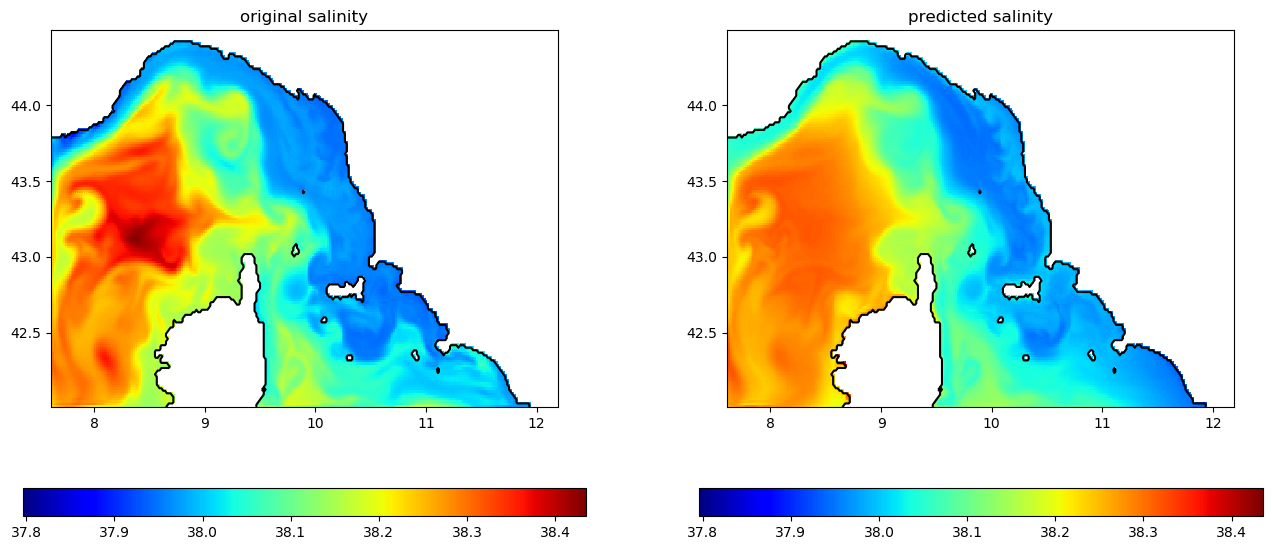

In [111]:
n = 3
cl = extrema(salt[isfinite.(salt)])
figure(figsize=(16,7))
subplot(1,2,1)
plotvar(salt[:,:,n],cl = cl)
title("original salinity");

subplot(1,2,2)
plotvar(salt_pred[:,:,n],cl = cl)
title("predicted salinity");


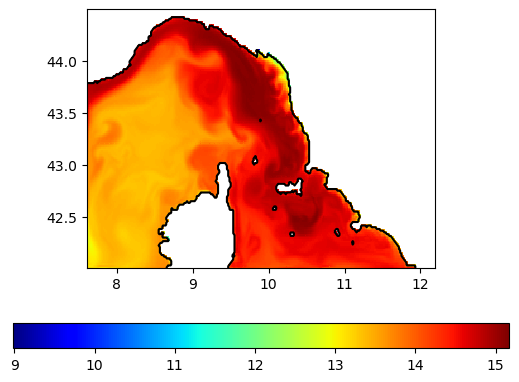

In [112]:
plotvar(temp[:,:,n])


# Final remarks

* Complex neural networks can take a long-time to converge
* A fast GPU can be beneficial
* Minimization can fail due to local minima
* Mini-batch approach (i.e. computing the gradient on a subset of the data) helps to converge to a global minimum.  